In [1]:
import datetime
import weatherMethods
import timeMethods
from imp import reload
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
reload(weatherMethods)
reload(timeMethods)

<module 'timeMethods' from '/home/liuyulin101/Desktop/Wind_Mining/timeMethods.py'>

In [206]:
%timeit '1230' in ['123' + str(k) for k in range(10000)]

The slowest run took 4.81 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 3.55 ms per loop


## Debug weatherMethods

In [4]:
# UTC Flight Departure Time
departureTime = datetime.datetime(2013, 1, 1, 13, 50)
arrivalTime = datetime.datetime(2013, 1, 1, 19, 30)
print(departureTime)

# This function downloads all the data needed for the flight
WindClass = weatherMethods.GetWindSpeed(departureTime, arrivalTime)
# meteoDT, winds, lvls, valid_timeTags

#Current position
lon = -90
lat = 43
# Current altitude (ft)
alt = 30000

# UTC time at currentpostion
t = datetime.datetime(2013, 1, 1, 18, 30)

# Last position
lonl = -89.9
latl= 43.1

# This function gives wind value at current position (km/h)
wind  = WindClass.getWind(lon, lat, alt, t, lonl, latl)

print(wind)

2013-01-01 13:50:00
-124.367689749


In [236]:
print(WindClass.final_timeTags)
print(len(WindClass.winds))

['002', '003', '006']
3


## Test on Trajectory Matching

In [3]:
VTrackPath = os.getcwd() + '/TFMS_NEW/New_IAHBOS2013.csv'
VTrack = pd.read_csv(VTrackPath, parse_dates=[6])

In [4]:
Sample = VTrack[VTrack.FID == 20130101632288]

In [118]:
Sample.head(3)

,FID,FlightIdx,ACID,ACT_DATE,DEP,ARR,Elap_Time,Lat,Lon,Alt,GroundSpeed,ID2,DT,Dist,Speed,CumDist
0,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:08:00,29.983333,-95.300000,8,159,471666-UAL386,0.0,0.000000,0.000000,0.000000
1,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:09:00,30.016667,-95.266667,26,253,471666-UAL386,60.0,2.647485,0.044125,2.647485
2,20130101632288,471666,UAL386,01-JAN-13 00:00:00,IAH,BOS,2013-01-01 01:11:00,30.166667,-95.233333,86,300,471666-UAL386,120.0,9.170856,0.076424,11.818341


In [242]:
st = time.time()
depTime = Sample.Elap_Time.iloc[0]
arrTime = Sample.Elap_Time.iloc[-1]

Position = Sample[['Lat','Lon','Alt']].values
Position[:,2] = Position[:,2] * 100
TimeStamp = Sample.Elap_Time

WindClass = weatherMethods.GetWindSpeed(depTime, arrTime)
lastPos = Position[0]

WindSpeed = [0]
for idx in range(Position.shape[0] - 1):

    curPos = Position[idx + 1]
    curTime = TimeStamp.iloc[idx+1]
    wind  = WindClass.getWind(curPos[1], curPos[0], curPos[2], curTime,lastPos[1], lastPos[0])
    WindSpeed.append(wind)
    lastPos = curPos
    
print(time.time() - st)

22.222797393798828


In [139]:
Sample['WindSpeed'] = 0
Sample.loc[1:,'WindSpeed'] = np.array(WindSpeed)
Sample['AirSpeed'] = Sample.GroundSpeed * 1.852 - Sample.WindSpeed
Sample['WindDist'] = Sample.AirSpeed * Sample.DT /3600 * 0.539957

/home/liuyulin101/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/liuyulin101/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/liuyulin101/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [145]:
print(sum(Sample.WindDist))
print(sum(Sample.Dist))

1260.33594474
1460.54414964


In [184]:
WindClass.meteoTime

datetime.datetime(2013, 1, 1, 0, 0)

## Try nearest neighbor

In [107]:
def press(alt):
    z = alt/3.28084
    return 1013.25*(1-(0.0065*z)/288.15)**5.255

# Returns the closest lvl from levels with altitude (atl)
def proxilvl(alt , lvls):
    p = press(alt)
    levels = np.array(sorted(lvls.keys()))
    return levels[np.abs(levels - p).argmin()]

In [114]:
uniquelvl = []
for alt in Position[:,2]:
    pro_lvl = proxilvl(alt,WindClass.lvls)
    if pro_lvl not in uniquelvl:
        uniquelvl.append(pro_lvl)

In [185]:
Winds = WindClass.winds
for i in range(len(uniquelvl)):
    u_wind = Winds[0][0][WindClass.lvls[uniquelvl[i]]].data(lat1 = 29.983, lat2 = 42.5499,lon1 = -95.3, lon2 = -70.967)
    u_windspeed = u_wind[0]
    u_lat = u_wind[1]
    u_lon = u_wind[2]
    
    v_wind = Winds[0][1][WindClass.lvls[uniquelvl[i]]].data(lat1 = 29.983, lat2 = 42.5499,lon1 = -95.3, lon2 = -70.967)
    v_windspeed = v_wind[0]
    v_lat = v_wind[1]
    v_lon = v_wind[2]
    if i == 0:
        u_wind_array = np.dstack((u_lat,u_lon,u_windspeed))[0]
        v_wind_array = np.dstack((v_lat,v_lon,v_windspeed))[0]
    else:
        u_wind_array = np.append(u_wind_array,np.dstack((u_lat,u_lon,u_windspeed))[0], axis = 0)
        v_wind_array = np.append(v_wind_array,np.dstack((v_lat,v_lon,v_windspeed))[0], axis = 0)
# v_wind = Winds[0][1][23].data(lat1 = 29.983, lat2 = 42.5499,lon1 = -95.3, lon2 = -70.967)

In [186]:
print(u_wind_array.shape)
print(v_wind_array.shape)

(533325, 3)
(533325, 3)


In [169]:
from sklearn.neighbors import KDTree, BallTree, NearestNeighbors

In [181]:
tree = KDTree(u_wind_array[:,:2], leaf_size = 30)              
near_idx = tree.query(Position[:,:2], k = 1, dualtree = False, return_distance = False)

In [180]:
%timeit near_idx = tree.query(Position[:,:2], k = 1, dualtree = False, return_distance = False)

The slowest run took 4.50 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 359 µs per loop


(-90, -89.5)

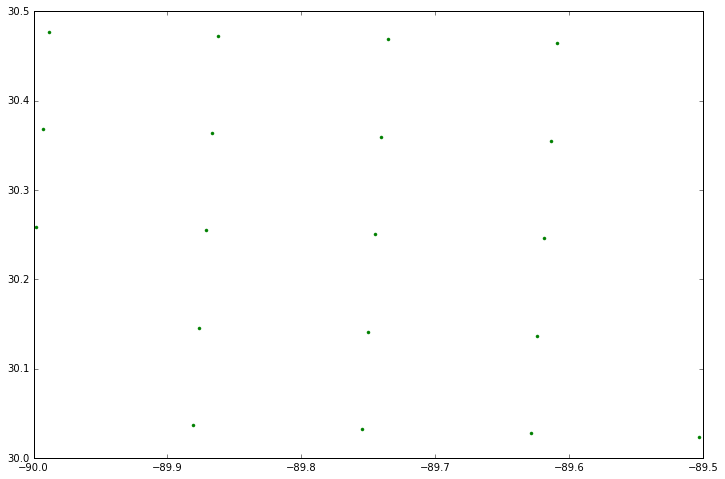

In [14]:
b = a(lat1 = 29.983, lat2 = 42.5499,lon1 = -95.3, lon2 = -70.967)
Poslat = b[1]
Poslon = b[2]
plt.figure(figsize = (12,8))
plt.plot(Poslon, Poslat, 'g.')
plt.plot(Position[:,1], Position[:,0],'r', lw = 2.5)
plt.ylim(30,30.5)
plt.xlim(-90,-89.5)

In [74]:
from shapely.geometry import LineString, Polygon, Point, MultiPoint

In [69]:
line = LineString([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])
dilated = line.buffer(0.5)

In [77]:
dilated.intersects(MultiPoint([(0, 0), (100, 10)]))

True

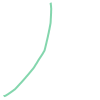

In [97]:
LineString(Position[:,:2])

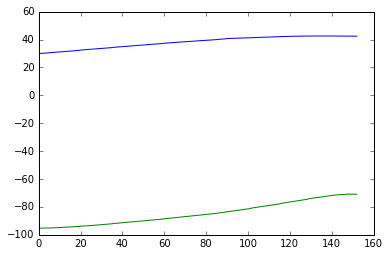

In [93]:
plt.plot(LineString(Position[:,:2]))

In [20]:
from weather.gributils import *

In [21]:
path = '/media/liuyulin101/YulinLiu/WindData'
datasrc = path + '/DATA/filtered_weather_data/namanl'

In [22]:
def ReadWind(fname):
    grbs = pygrib.open(fname)
    uin = grbs.select(shortName='u', typeOfLevel='isobaricInhPa')
    vin = grbs.select(shortName='v', typeOfLevel='isobaricInhPa')
    grbs.close()
    return (uin, vin)


In [24]:
st = time.time()
path = '/media/liuyulin101/YulinLiu/WindData/DATA/filtered_weather_data/namanl/'
i = 0
WindDict = {}
for filtered_wind in os.listdir(path):
    i += 1
    fname = path + filtered_wind
#     if i <= 5:
#         WindDict[filtered_wind[11:28]] = ReadWind(fname)
#     else:
#         break
time.time() - st

5.548418998718262

In [228]:
for k in range(1,2):
    print(k)

1


In [212]:
fname = '/media/liuyulin101/YulinLiu/WindData/DATA/filtered_weather_data/namanl/namanl_218_20130923_1800_000.grb'

In [229]:
k = os.listdir('/media/liuyulin101/YulinLiu/WindData/DATA/filtered_weather_data/namanl')

In [231]:
[1,2,3,4,5][2:]

[3, 4, 5]

In [224]:
%timeit fname[-32:] in k

The slowest run took 4.78 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 125 µs per loop


In [213]:
%timeit pygrib.open(fname)

The slowest run took 43.98 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 33.4 ms per loop


In [87]:
for grb in grbs:
    grb

In [105]:
grbs.select(maximum =, shortName='u', typeOfLevel='isobaricInhPa')

ValueError: no matches found

In [25]:
import pickle

In [31]:
picklefile = open('WindDictionary.p','w')
pickle.dump(WindDict, picklefile)
picklefile.close()

RuntimeError: b'Key/value not found'

In [110]:
%timeit grbs = pygrib.open(path + filtered_wind)

The slowest run took 35.73 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 49.6 ms per loop


In [ ]:
%timeit uin = grbs.select(shortName='u', typeOfLevel='isobaricInhPa')